In [ ]:
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow_addons as tfa

from tensorflow.keras.preprocessing import image as tfk_image
from tensorflow.keras.preprocessing.image import ImageDataGenerator as tfk_ImageDataGenerator

from tensorflow.python.keras.applications.efficientnet import EfficientNetB7 as tfk_BaseModel
from tensorflow.python.keras.applications.efficientnet import preprocess_input as tfk_preprocess_input

# pip install git+https://github.com/docPhil99/ImageDataAugmentor
from ImageDataAugmentor.image_data_augmentor import ImageDataAugmentor
import albumentations as A

import datetime, os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set();
from PIL import Image, ImageEnhance

from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, log_loss, accuracy_score
from sklearn.preprocessing import OneHotEncoder

## Load Dataset

In [2]:
pd_train = pd.read_csv('shopee-product-detection-dataset/train.csv').sort_values(by=['filename'])
pd_confusing_images = pd.read_csv('shopee-product-detection-dataset/confusing_images_2__mistake_ratio=0.9.csv').sort_values(by=['filename'])

pd_train['dir_filename']            = pd_train.apply(lambda x: '{:02d}/{}'.format(x.category, x.filename), axis=1)
pd_confusing_images['dir_filename'] = pd_confusing_images.apply(lambda x: '{:02d}/{}'.format(x.category, x.filename), axis=1)

In [3]:
mask = ~pd_train.set_index('dir_filename').index.isin(pd_confusing_images.set_index('dir_filename').index)
pd_train_clean = pd_train.loc[mask].copy()
pd_train_clean['category'] = pd_train_clean['category'].apply(lambda x : '{:02d}'.format(x))
pd_train_clean.head()

,filename,category,dir_filename
50947,00017f8bf9d8a34dab8f9707a378dbe5.jpg,38,38/00017f8bf9d8a34dab8f9707a378dbe5.jpg
31622,00022314f9c58eb20d248ed239db3a52.jpg,16,16/00022314f9c58eb20d248ed239db3a52.jpg
34234,0002d098348d8358c44032903e117ade.jpg,28,28/0002d098348d8358c44032903e117ade.jpg
12787,000367a6ec58e9d1e4bc340d8d871dab.jpg,34,34/000367a6ec58e9d1e4bc340d8d871dab.jpg
38157,00042ddb52b8b5046c4f2eaee8c948ed.jpg,10,10/00042ddb52b8b5046c4f2eaee8c948ed.jpg


In [7]:
# pd_train_clean = pd.read_csv('shopee-product-detection-dataset/train.csv').sort_values(by=['filename'])
# pd_train_clean['dir_filename'] = pd_train_clean.apply(lambda x: '{:02d}/{}'.format(x.category, x.filename), axis=1)
# pd_train_clean['category'] = pd_train_clean['category'].apply(lambda x : '{:02d}'.format(x))
# pd_train_clean.head()

,filename,category,dir_filename
30694,0000ffaa6ce77e3dde38bcefa039a4a4.jpg,16,16/0000ffaa6ce77e3dde38bcefa039a4a4.jpg
50947,00017f8bf9d8a34dab8f9707a378dbe5.jpg,38,38/00017f8bf9d8a34dab8f9707a378dbe5.jpg
31622,00022314f9c58eb20d248ed239db3a52.jpg,16,16/00022314f9c58eb20d248ed239db3a52.jpg
34234,0002d098348d8358c44032903e117ade.jpg,28,28/0002d098348d8358c44032903e117ade.jpg
12787,000367a6ec58e9d1e4bc340d8d871dab.jpg,34,34/000367a6ec58e9d1e4bc340d8d871dab.jpg


In [8]:
classes = np.unique(pd_train_clean['category'])
classes

array(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21',
       '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32',
       '33', '34', '35', '36', '37', '38', '39', '40', '41'], dtype=object)

In [9]:
input_shape = (256, 256, 3)
# input_shape = (512, 512, 3)
batch_size=128

In [10]:
AUGMENTATIONS = A.Compose([
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.Rotate(),
    A.OneOf([
        A.RandomContrast(),
        A.RandomGamma(),
        A.RandomBrightness(),
    ], p = 0.3),
    A.OneOf([
        A.ElasticTransform(
            alpha = 120,
            sigma = 120 * 0.05,
            alpha_affine = 120 * 0.03
        ),
        A.GridDistortion(),
        A.OpticalDistortion(
            distort_limit = 2,
            shift_limit = 0.5
        ),
    ], p = 0.3),
    A.OneOf([
        A.Cutout(
            num_holes=1,
            max_h_size=128,
            max_w_size=128
        ),
        A.GridDropout(
            ratio=0.25,
            holes_number_x=8,
            holes_number_y=8
        ),
    ], p=1),
])

In [11]:
train_datagen = ImageDataAugmentor(
    preprocess_input=tfk_preprocess_input,
    validation_split=0.1,
    augment=AUGMENTATIONS,
)

train_generator = train_datagen.flow_from_dataframe(
    pd_train_clean,
    directory='shopee-product-detection-dataset/train/',
    x_col='dir_filename',
    y_col='category',
    target_size=input_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

val_generator = train_datagen.flow_from_dataframe(
    pd_train_clean,
    directory='shopee-product-detection-dataset/train/',
    x_col='dir_filename',
    y_col='category',
    target_size=input_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='validation'
)

Found 94853 validated image filenames belonging to 42 classes.
Found 10539 validated image filenames belonging to 42 classes.


## Prepare Model

In [8]:
base_model = tfk_BaseModel(input_shape=input_shape, weights='imagenet', include_top=False)

In [9]:
TYPE = 3
if TYPE == 1:
    for layer in base_model.layers[:-18]:
        layer.trainable = False
    model = tfk.Sequential([
        base_model,
        tfk.layers.GlobalMaxPooling2D(),
        tfk.layers.Dense(512, activation='relu'),
        tfk.layers.Dense(128, activation='relu'),
        tfk.layers.Dense(42, activation='softmax', name='output_layer'),
    ])
elif TYPE == 2:
    model = tfk.Sequential([
        base_model,
        tfk.layers.GlobalMaxPooling2D(),
        tfk.layers.Dropout(rate=0.2),
        tfk.layers.Dense(42, activation='softmax', name='output_layer'),
    ])
    base_model.trainable = False
elif TYPE == 3:
    for layer in base_model.layers[:-18]:
        layer.trainable = False
    model = tfk.Sequential([
        base_model,
        tfk.layers.GlobalMaxPooling2D(),
        tfk.layers.Dropout(rate=0.2),
        tfk.layers.Dense(42, activation='softmax', name='output_layer'),
    ])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb7 (Model)       (None, 8, 8, 2560)        64097687  
_________________________________________________________________
global_max_pooling2d (Global (None, 2560)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2560)              0         
_________________________________________________________________
output_layer (Dense)         (None, 42)                107562    
Total params: 64,205,249
Trainable params: 7,950,282
Non-trainable params: 56,254,967
_________________________________________________________________


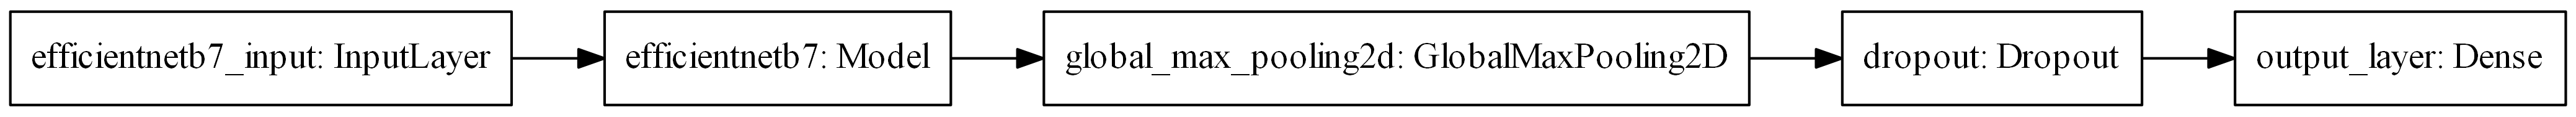

In [11]:
tfk.utils.plot_model(model, rankdir='LR', dpi=300, show_shapes=False)

## Train Top Layers of Model

In [12]:
model = tfk.models.load_model('model_aug_8.h5')

train step size: 741
  val step size: 82


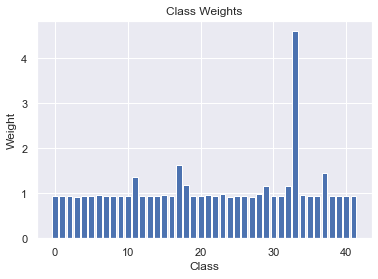

In [13]:
class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(train_generator.classes),
                                                  train_generator.classes)
class_weights = {i : class_weights[i] for i in range(len(class_weights))}
plt.title("Class Weights")
plt.ylabel("Weight")
plt.xlabel("Class")
plt.bar(class_weights.keys(), class_weights.values())

train_step_size = train_generator.n//train_generator.batch_size
val_step_size   = val_generator.n//val_generator.batch_size
print("train step size:", train_step_size)
print("  val step size:", val_step_size)

In [14]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.3,
    patience=7,
    min_lr=1e-6
)

early_stop = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=20,
    restore_best_weights=True
)

log_dir = os.path.join(".model_files/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

checkpoint = tfk.callbacks.ModelCheckpoint(
    filepath = log_dir + '/ckpt/',
    save_freq ='epoch',
    save_best_only=True,
    monitor='val_accuracy'
)

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=0,
    update_freq=100,
    write_graph=False,
    profile_batch = 0
)

class LRTensorBoard(tf.keras.callbacks.TensorBoard):
    def __init__(self, log_dir, **kwargs):  # add other arguments to __init__ if you need
        super().__init__(log_dir=log_dir, **kwargs)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        lr_sched = getattr(self.model.optimizer, "lr", None)
        logs.update({'lr': tf.keras.backend.get_value(lr_sched(tf.cast(self.model.optimizer.iterations, tf.float32)))})
        super().on_epoch_end(epoch, logs)

lr_tensorboard_callback = LRTensorBoard(log_dir=log_dir)
        
#tqdm_callback = tfa.callbacks.TQDMCallback()

In [16]:
lr_schedule = tfa.optimizers.ExponentialCyclicalLearningRate(
    initial_learning_rate=1e-6,
    maximal_learning_rate=1e-3,
    step_size=2*train_generator.n//batch_size
)

model.compile(optimizer=tfk.optimizers.Adam(learning_rate=1e-4),
              loss=tfk.losses.CategoricalCrossentropy(label_smoothing=0.1),
              metrics=['accuracy'])

In [17]:
history = model.fit(train_generator,
                    initial_epoch=0,
                    epochs=200,
                    steps_per_epoch=200,
                    validation_steps=20,
                    validation_data=val_generator,
                    class_weight=class_weights,
                    callbacks=[#reduce_lr,
                               early_stop, 
                               #checkpoint, 
                               tensorboard_callback,
                               lr_tensorboard_callback,
                               #tqdm_callback
                              ]
                   )

Epoch 1/200
200/200 [==============================] - 335s 2s/step - loss: 2.1503 - accuracy: 0.6828 - val_loss: 2.0912 - val_accuracy: 0.6934 - lr: 1.3582e-04
Epoch 2/200
200/200 [==============================] - 332s 2s/step - loss: 2.1409 - accuracy: 0.6846 - val_loss: 2.0729 - val_accuracy: 0.6902 - lr: 2.7064e-04
Epoch 3/200
200/200 [==============================] - 332s 2s/step - loss: 2.1377 - accuracy: 0.6856 - val_loss: 2.0723 - val_accuracy: 0.6969 - lr: 4.0545e-04
Epoch 4/200
200/200 [==============================] - 332s 2s/step - loss: 2.1464 - accuracy: 0.6757 - val_loss: 2.0405 - val_accuracy: 0.7047 - lr: 5.4027e-04
Epoch 5/200
200/200 [==============================] - 331s 2s/step - loss: 2.1556 - accuracy: 0.6773 - val_loss: 2.0910 - val_accuracy: 0.6906 - lr: 6.7509e-04
Epoch 6/200
200/200 [==============================] - 331s 2s/step - loss: 2.1591 - accuracy: 0.6712 - val_loss: 2.0685 - val_accuracy: 0.6918 - lr: 8.0991e-04
Epoch 7/200
200/200 [=============

In [18]:
model.save('model_aug_9.h5')

## Train Whole Model

In [8]:
model = tfk.models.load_model('model_aug_8.h5')

In [9]:
for layer in model.layers[0].layers[-36:]:
    layer.trainable = True

In [14]:
lr_schedule = tfa.optimizers.ExponentialCyclicalLearningRate(
    initial_learning_rate=1e-6,
    maximal_learning_rate=5e-4,
    step_size=2*train_generator.n//batch_size
)

model.compile(optimizer=tfk.optimizers.Adam(learning_rate=lr_schedule),
              loss=tfk.losses.CategoricalCrossentropy(label_smoothing=0.2),
              metrics=['accuracy'])

In [15]:
history = model.fit(train_generator,
                    initial_epoch=77,
                    epochs=200,
                    steps_per_epoch=200,
                    validation_steps=20,
                    validation_data=val_generator,
                    class_weight=class_weights,
                    callbacks=[#reduce_lr,
                               early_stop, 
                               #checkpoint, 
                               #tensorboard_callback,
                               #lr_tensorboard_callback,
                               #tqdm_callback
                              ]
                   )

Epoch 78/200
105/200 [==============>...............] - ETA: 2:28 - loss: 1.9443 - accuracy: 0.7616

ResourceExhaustedError:  OOM when allocating tensor with shape[24576,129,129] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node sequential/efficientnetb7/block2a_dwconv_pad/Pad (defined at <ipython-input-15-e87bb1096fd2>:9) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_69080]

Function call stack:
train_function


## Testing

In [19]:
# model = tfk.models.load_model('model_clean_3.h5')

In [20]:
clean_datagen = tfk_ImageDataGenerator(
    preprocessing_function=tfk_preprocess_input,
)

clean_generator = clean_datagen.flow_from_dataframe(
    pd_train_clean,
    directory='shopee-product-detection-dataset/train/',
    x_col='dir_filename',
    y_col='category',
    target_size=input_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
)

Found 105392 validated image filenames belonging to 42 classes.


In [21]:
%%time
y_pred = []
y_true = []

for i in range(50):
    if (i+1) % 10 == 0:
        print("step:", i+1)
    x, y = next(iter(clean_generator))
    y_true.extend(y)
    y_pred.extend(model.predict(x))

y_pred = np.array(y_pred)
y_true = np.array(y_true)

step: 10
step: 20
step: 30
step: 40
step: 50
Wall time: 1min 43s


In [22]:
matrix = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))

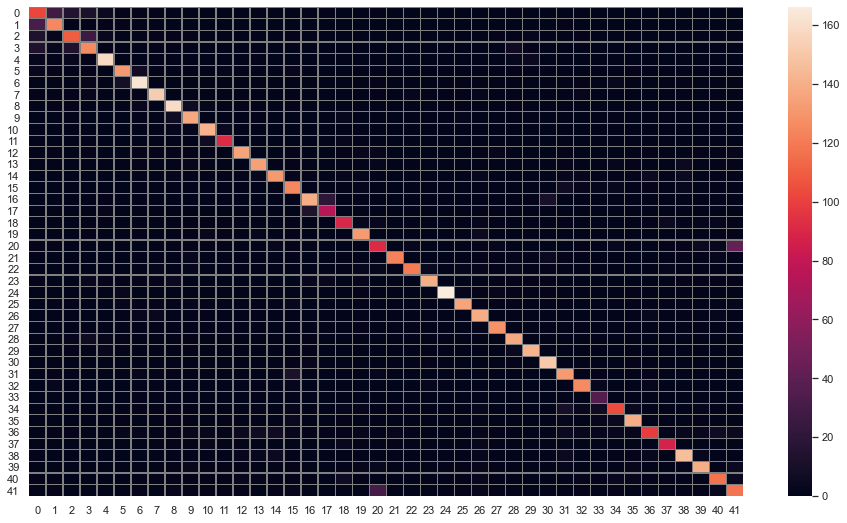

In [23]:
plt.figure(figsize = (16,9))
sns.heatmap(matrix, linecolor='grey', linewidth=0.1)
plt.savefig('confusion_matrix.png', 
            #transparent=True,
            bbox_inches='tight')

In [24]:
def label_smoother(x, alpha=0.1):
    return (1 - alpha) * x + alpha / x.shape[1]

In [25]:
loss     = tfk.losses.categorical_crossentropy(y_pred, label_smoother(y_true, alpha=0.2)).numpy().mean()
accuracy = accuracy_score(y_pred.argmax(axis=1), y_true.argmax(axis=1))

print("Loss:", loss)
print("Accuracy:", accuracy)

Loss: 2.345422
Accuracy: 0.825


## Generate Submission

In [26]:
pd_test = pd.read_csv('shopee-product-detection-dataset/test.csv')
pd_test.head()

,filename,category
0,fd663cf2b6e1d7b02938c6aaae0a32d2.jpg,43
1,c7fd77508a8c355eaab0d4e10efd6b15.jpg,43
2,127f3e6d6e3491b2459812353f33a913.jpg,43
3,5ca4f2da11eda083064e6c36f37eeb81.jpg,43
4,46d681a542f2c71be017eef6aae23313.jpg,43


In [27]:
test_datagen = tfk_ImageDataGenerator(
    preprocessing_function=tfk_preprocess_input
)

test_generator = test_datagen.flow_from_dataframe(
    pd_test,
    directory='shopee-product-detection-dataset/test/',
    x_col='filename',
    target_size=input_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode=None,
    shuffle=False,
)

Found 12186 validated image filenames.


In [28]:
y_pred = model.predict(test_generator, verbose=1, steps=test_generator.n//batch_size+1)
y_pred = y_pred[:test_generator.n]

96/96 [==============================] - 131s 1s/step


In [29]:
pd_submission = pd_test.copy()
pd_submission['category'] = list(map(lambda x : '{:02d}'.format(x), y_pred.argmax(axis=1)))
pd_submission.head()

,filename,category
0,fd663cf2b6e1d7b02938c6aaae0a32d2.jpg,41
1,c7fd77508a8c355eaab0d4e10efd6b15.jpg,27
2,127f3e6d6e3491b2459812353f33a913.jpg,04
3,5ca4f2da11eda083064e6c36f37eeb81.jpg,22
4,46d681a542f2c71be017eef6aae23313.jpg,12


In [30]:
pd_submission.to_csv('submission_6.csv', index=False)

In [31]:
pd_submission_1 = pd.read_csv('submission_1.csv')
pd_submission_1['category'] = pd_submission_1['category'].apply(lambda x : '{:02d}'.format(x))
pd_submission_1.columns = ['filename', 'category_1']
pd_submission_1 = pd_submission_1.merge(pd_submission.sort_values(by='filename'), on='filename')
pd_iba = pd_submission_1[pd_submission_1['category_1'] != pd_submission_1['category']]
print(len(pd_iba), len(pd_submission_1))
pd_iba.head(20)

1596 12186


,filename,category_1,category
9,0022bd7f6b85fe98edd3291d9824ee6c.jpg,08,09
50,00fcb7e22074245e8b6ee99f89d146fd.jpg,23,03
56,0126dd271b3871c85dacdda4dc4af939.jpg,30,07
59,0144be7cd37da73b3e3a15953d08a47c.jpg,23,06
63,0174bae73c34c39bc70393186cee790b.jpg,21,34
78,01de1bcd101edd2a30e8d9517adbfa56.jpg,10,18
80,01e8c3b590b0392048537980df759ec8.jpg,16,17
86,01f69dcfe8946f2396ca2830a4befcd0.jpg,02,03
96,02395ca8f389dffa53b9a5c0d23af85d.jpg,35,26
118,02bad0d7821d9520ae9c939287664a4c.jpg,35,15


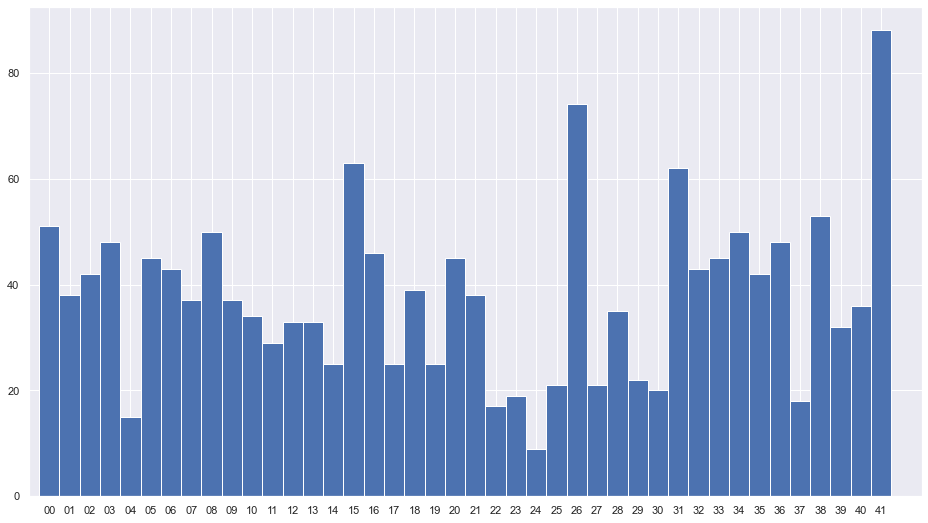

In [32]:
plt.figure(figsize=(16, 9))
plt.hist(pd_iba['category'].sort_values(), bins=np.arange(43)-0.5)
plt.xlim(-1, 43)
plt.show()